In [1]:
import Parity_Data_Generator
import InputToParityESN
# import ParityToOutputESN
import numpy as np
from pyESN import ESN
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import time

rng = np.random.RandomState(42)

In [2]:
N = 20000   # number of datapoints
n = 3       # n-parity

start_time = time.time()
# produce Data
bits, parity, target = Parity_Data_Generator.generateParityData(N, n, randomstate=rng)

# Divide in training and test data
traintest_cutoff = int(np.ceil(0.7 * len(bits)))
train_bits, test_bits = bits[:traintest_cutoff], bits[traintest_cutoff:]
train_parity, test_parity = parity[:traintest_cutoff], parity[traintest_cutoff:]
train_targets, test_targets = target[:traintest_cutoff], target[traintest_cutoff:]

print("--- %s seconds ---" % (time.time() - start_time))

--- 13.031265020370483 seconds ---


In [3]:
def runSomeConfigs(spectral_rad, leak_r,num_neurons=500):
#     print("Spectral-radius:",spectral_rad, "leak-rate:", leak_r)
    nParityESN = ESN(n_inputs=1,
                          n_outputs=1,
                          n_reservoir=num_neurons,  # from 200 onwards test error decreases significantly
                          spectral_radius=spectral_rad,  # high spectral rad is better (high fluctuations 0->1->0)
                          leak_rate= leak_r,   # adjust leak_rate
                          sparsity=0.95,
                          noise=0.001,
                          input_shift=0,
                          input_scaling=3,  # 3 seems to be fine. Maybe use lower
                          teacher_scaling=1.12,
                          teacher_shift=-0.7,
                          out_activation=np.tanh,
                          inverse_out_activation=np.arctanh,
                          random_state=rng,
                          silent=False)
    # print(np.shape(bits),np.shape(parity),np.shape(target))
    nParityESN.fit(train_bits, train_parity)
    pred_test = nParityESN.predict(test_bits)

    #### not rounding
    predictedParity = pred_test # not rounding
    #### Rounding
#     better_pred_test = []           # Maybe don't round and return "true" results from pred_test
#     for x in pred_test:
#         better_pred_test.append(0 if x < 0.5 else 1)
#     predictedParity = np.array(better_pred_test).reshape(-1,1)
#     print(test_parity[40030:40100].reshape(-1))
#     print(predictedParity[40030:40100].reshape(-1))
    
    print("Testing error")
    test_error = np.sqrt(np.mean((predictedParity - test_parity) ** 2))
    print(test_error)
    return test_error

In [11]:
# num_neurons = [500, 600, 700, 800, 900, 1000]
num_neurons = [500]
# num_neurons = [100, 200, 300, 400, 500, 600, 700, 800]
# l_rate = np.linspace(0.05, 0.2, num=4)
l_rate =[0.1]
# l_rate = [0.1,0.2,0.3]
# sp_rad = np.linspace(0.9, 1.0, num=5)
sp_rad = [0.9,0.92,0.94,0.96,0.98, 1]

run_time = time.time()
iterations, iterationcount = len(num_neurons)*len(sp_rad)*len(l_rate), 0
leak_rate_list = []
spectral_radius_list = []
errors = []
all_errors = [{} for _ in range(len(num_neurons))]
for i,n in enumerate(num_neurons):
    leak_rate_list = []
    spectral_radius_list = []
    errors = []
    for l in l_rate:
        for s in sp_rad:
            print("Neurons:", n, "Spectral-radius:", s, "Leak-rate:", l)
            leak_rate_list.append(l)
            spectral_radius_list.append(s)
            errors.append(runSomeConfigs(s,l,n))
            iterationcount = iterationcount + 1
            print("--- Progress: {:.2f}% --- {:.2f} minutes ---".format(iterationcount/iterations*100, ((time.time() - run_time)/60) ))
    ## Save leak-rate,spectral-radius and error in dictionary
    all_errors[i] = leak_rate_list, spectral_radius_list, errors
            
print("Total time for Testbench:")
print("--- {:.2f} seconds ---".format(time.time() - run_time))
print("--- {:.2f} minutes ---".format(((time.time() - run_time)/60)))

Neurons: 500 Spectral-radius: 0.9 Leak-rate: 0.1
harvesting states...
fitting...
training error:
0.122818370875
Testing error
0.750994426339
--- Progress: 16.67% --- 0.74 minutes ---
Neurons: 500 Spectral-radius: 0.92 Leak-rate: 0.1
harvesting states...
fitting...
training error:
0.123023082377
Testing error
0.460610795633
--- Progress: 33.33% --- 1.53 minutes ---
Neurons: 500 Spectral-radius: 0.94 Leak-rate: 0.1
harvesting states...
fitting...
training error:
0.1235657703
Testing error
0.337526994767
--- Progress: 50.00% --- 2.32 minutes ---
Neurons: 500 Spectral-radius: 0.96 Leak-rate: 0.1
harvesting states...
fitting...
training error:
0.122772807441
Testing error
0.443656378939
--- Progress: 66.67% --- 3.02 minutes ---
Neurons: 500 Spectral-radius: 0.98 Leak-rate: 0.1
harvesting states...
fitting...
training error:
0.127448829518
Testing error
0.497895221076
--- Progress: 83.33% --- 3.72 minutes ---
Neurons: 500 Spectral-radius: 1 Leak-rate: 0.1
harvesting states...
fitting...
trai

In [12]:
import pickle
#### Save Data
with open('datasaveSlow.p', 'wb') as outputFile:
    pickle.dump(all_errors, outputFile)
    pickle.dump(num_neurons, outputFile)
    pickle.dump(l_rate, outputFile)
    pickle.dump(sp_rad, outputFile)
#### Load Data
# with open('datasaveSlow.p', 'rb') as inputFile:
#     all_errors = pickle.load(inputFile)
#     num_neurons = pickle.load(inputFile)
#     l_rate = pickle.load(inputFile)
#     sp_rad = pickle.load(inputFile)

In [13]:
import plotly.plotly as py
import plotly.graph_objs as go
py.sign_in('HansBambel', 'T0F76G8esWCDFNmIVEUv')

# c= ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, len(all_errors))]
c= ["blue", "orange", "green", "cyan", "yellow", "magenta", "red", "black"]
data = []
for i, n in enumerate(all_errors):

    x, y, z = all_errors[i]

    trace = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        name=(str(num_neurons[i])+" Neurons"),
        mode='markers',
        marker=dict(
            size=7,
#             color=c[i],                # set color to an array/list of desired values
            colorscale='Viridis',   # choose a colorscale
            opacity=0.8
        )
    )
    data.append(trace)

# data = [trace1]
layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     ),
#     go.zaxis=dict(
#         range=[0, 0.8]
#     ),
    scene=go.Scene(
        xaxis=go.XAxis(title='x = Leak-Rate'),
        yaxis=go.YAxis(title='y = Spectral Radius'),
        zaxis=go.ZAxis(title='z = Error')
        )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='3d-scatter-errors for different Reservoirsizes')

In [14]:
nParityESN = ESN(n_inputs=1,
                          n_outputs=1,
                          n_reservoir=500,  # from 200 onwards test error decreases significantly
                          spectral_radius=0.95,  # high spectral rad is better (high fluctuations 0->1->0)
                          leak_rate= 0.1,   # adjust leak_rate
                          sparsity=0.95,     # 0.95
                          noise=0.01,      # 0.001
                          input_shift=-0.5,    # 0
                          input_scaling=3,  # 3 seems to be fine. Maybe use lower
                          teacher_scaling=1.12,
                          teacher_shift=-0.7,
                          out_activation=np.tanh,
                          inverse_out_activation=np.arctanh,
                          random_state=rng,
                          silent=False)
nParityESN.fit(train_bits, train_parity)

harvesting states...
fitting...
training error:
0.144171526702


array([[ 0.62504002],
       [ 0.37869038],
       [ 0.29360463],
       ..., 
       [-0.03280054],
       [-0.08573266],
       [-0.05423811]])

In [15]:
##### Create Training Data for fastESN with output from slowESN
start_time = time.time()

new_rng = np.random.RandomState(1337)
new_N, new_n = 20000, 3
new_bits, new_parity, new_target = Parity_Data_Generator.generateParityData(new_N, new_n, randomstate=new_rng)

# Divide in training and test data
traintest_cutoff = int(np.ceil(0.7 * len(bits)))
new_train_bits, new_test_bits = new_bits[:traintest_cutoff], new_bits[traintest_cutoff:]
# new_train_parity, new_test_parity = new_parity[:traintest_cutoff], new_parity[traintest_cutoff:]
new_train_targets, new_test_targets = new_target[:traintest_cutoff], new_target[traintest_cutoff:]

train_predicted_parity = nParityESN.predict(new_train_bits)
test_predicted_parity = nParityESN.predict(new_test_bits)

print("--- %s seconds ---" % (time.time() - start_time))

--- 43.20354342460632 seconds ---


In [16]:
#### FastESN ####
def runSomeFastConfigs(spectral_rad, leak_r,num_neurons=100):
    outputESN = ESN(n_inputs=1,
                              n_outputs=1,
                              n_reservoir=num_neurons,  
                              spectral_radius=spectral_rad,  # high spectral rad is better (high fluctuations 0->1->0)
                              leak_rate= leak_r,   # adjust leak_rate
                              sparsity=0.95,
                              noise=0.001,
                              input_shift=0,
                              input_scaling=3,  # 3 seems to be fine. Maybe use lower
                              teacher_scaling=1.12,
                              teacher_shift=-0.4,
                              out_activation=np.tanh,
                              inverse_out_activation=np.arctanh,
                              random_state=new_rng,
                              silent=False)
        # print(np.shape(bits),np.shape(parity),np.shape(target))
    outputESN.fit(train_predicted_parity, train_targets)
    pred_test = outputESN.predict(test_predicted_parity)
        
    print("Testing error")
    test_error = np.sqrt(np.mean((pred_test - test_targets) ** 2))
    print(test_error)
    return test_error

In [20]:
num_neurons_fast = [100]
l_rate_fast = np.linspace(0.4, 1, num=7)
# l_rate_fast = [0.6]
sp_rad_fast = np.linspace(0.8, 1, num=3)
# sp_rad_fast = [0.95]

run_time = time.time()
iterations, iterationcount = len(num_neurons_fast)*len(sp_rad_fast)*len(l_rate_fast), 0
leak_rate_list = []
spectral_radius_list = []
errors = []
all_errors_fast = [{} for _ in range(len(num_neurons_fast))]
for i,n in enumerate(num_neurons_fast):
    leak_rate_list = []
    spectral_radius_list = []
    errors = []
    for l in l_rate_fast:
        for s in sp_rad_fast:
            print("Neurons:", n, "Spectral-radius:", s, "Leak-rate:", l)
            leak_rate_list.append(l)
            spectral_radius_list.append(s)
            errors.append(runSomeFastConfigs(s,l,n))
            iterationcount = iterationcount + 1
            print("--- Progress: {:.2f}% --- {:.2f} minutes ---".format(iterationcount/iterations*100, ((time.time() - run_time)/60) ))
    ## Save leak-rate,spectral-radius and error in dictionary
    all_errors_fast[i] = leak_rate_list, spectral_radius_list, errors
            
print("Total time for Testbench:")
print("--- {:.2f} seconds ---".format(time.time() - run_time))
print("--- {:.2f} minutes ---".format(((time.time() - run_time)/60)))

Neurons: 100 Spectral-radius: 0.8 Leak-rate: 0.4
harvesting states...
fitting...
training error:
0.0583360081749
Testing error
0.132088857641
--- Progress: 4.76% --- 0.21 minutes ---
Neurons: 100 Spectral-radius: 0.9 Leak-rate: 0.4
harvesting states...
fitting...
training error:
0.0575312713507
Testing error
0.135821208283
--- Progress: 9.52% --- 0.42 minutes ---
Neurons: 100 Spectral-radius: 1.0 Leak-rate: 0.4
harvesting states...
fitting...
training error:
0.0593147390272
Testing error
0.131459830294
--- Progress: 14.29% --- 0.62 minutes ---
Neurons: 100 Spectral-radius: 0.8 Leak-rate: 0.5
harvesting states...
fitting...
training error:
0.0499788992488
Testing error
0.132013782323
--- Progress: 19.05% --- 0.85 minutes ---
Neurons: 100 Spectral-radius: 0.9 Leak-rate: 0.5
harvesting states...
fitting...
training error:
0.0514426625998
Testing error
0.133350104955
--- Progress: 23.81% --- 1.05 minutes ---
Neurons: 100 Spectral-radius: 1.0 Leak-rate: 0.5
harvesting states...
fitting...
t

In [21]:
import pickle
#### Save Data
with open('datasaveFast.p', 'wb') as outputFile:
    pickle.dump(all_errors_fast, outputFile)
    pickle.dump(num_neurons_fast, outputFile)
    pickle.dump(l_rate_fast, outputFile)
    pickle.dump(sp_rad_fast, outputFile)
#### Load Data
# with open('datasaveFast.p', 'rb') as inputFile:
#     all_errors_fast = pickle.load(inputFile)
#     num_neurons_fast = pickle.load(inputFile)
#     l_rate_fast = pickle.load(inputFile)
#     sp_rad_fast = pickle.load(inputFile)

<IPython.core.display.Javascript object>


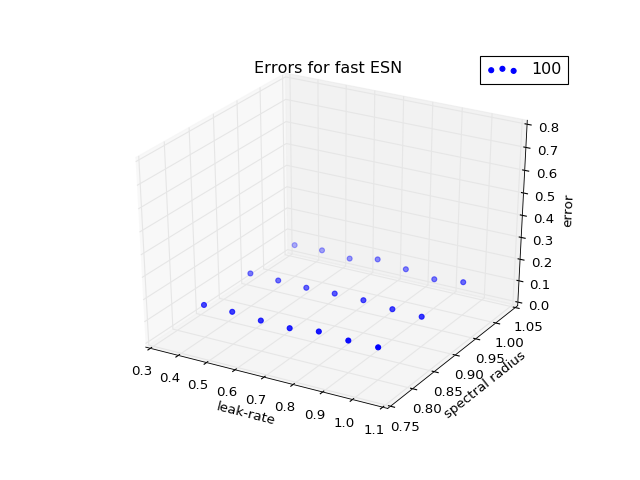

In [22]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

colors=["blue", "orange", "green", "cyan", "yellow", "magenta", "red", "black"]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, n in enumerate(all_errors_fast):

    x, y, z = all_errors_fast[i]
    
    ax.set_zlim(0, 0.8)
    ax.scatter(x, y, z, color=colors[i], label=(num_neurons_fast[i]))
    
    ax.set_xlabel('leak-rate')
    ax.set_ylabel('spectral radius')
    ax.set_zlabel('error')
ax.set_title("Errors for fast ESN")
ax.legend()
plt.show()

In [23]:
import plotly.plotly as py
import plotly.graph_objs as go
py.sign_in('HansBambel', 'T0F76G8esWCDFNmIVEUv')

# c= ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, len(all_errors_fast))]
c= ["blue", "orange", "green", "cyan", "yellow", "magenta", "red", "black"]
data = []
for i, n in enumerate(all_errors_fast):

    x, y, z = all_errors_fast[i]

    trace = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        name=(str(num_neurons_fast[i])+" Neurons"),
        mode='markers',
        marker=dict(
            size=7,
#             color=c[i],                # set color to an array/list of desired values
            colorscale='Viridis',   # choose a colorscale
            opacity=0.8
        )
    )
    data.append(trace)

# data = [trace1]
layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     ),
#     go.zaxis=dict(
#         range=[0, 0.8]
#     ),
    scene=go.Scene(
        xaxis=go.XAxis(title='x = Leak-Rate'),
        yaxis=go.YAxis(title='y = Spectral Radius'),
        zaxis=go.ZAxis(title='z = Error')
        )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='3d-scatter-errors for different Reservoirsizes')